In [1]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
import os
import pandas as pd
import numpy as np
import re
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor

## read data and clean column names

In [2]:
#Spotfire link: 
#https://spotfiremrlprd.merck.com/spotfire/wp/analysis?file=/BOB%20Project%20Support/ELN%20BioAssay/PSCS/Self%20Service%20-%20DPS%20Protein%20Formulation%20Characterization/DPS%20Protein%20Formulation%20Characterization
#os.chdir('c:\\Users\\chenya68\\OneDrive - Merck Sharp & Dohme LLC\\Documents\\gp-data')
os.chdir('/Users/chenya68/Documents/GitHub/BFO')
df = pd.read_csv('data/dps-alldata.csv')
print(len(df))
df.head()

2743


,Import Date,ISID,Project,Protein,Modality,Control Type,Stress Condition,Temp. (°C),Time (Days),Well ID,...,PI,MW,IMPORTED_DATA_FILE_NAME,TARGETS,REAGENT_TYPE,Simplified Excipients,1st Excipient in Sample,2nd Excipient in Sample,#Conc for Excipient1,Origin of data
0,1/6/2023,ferguhei,aTau,03BHZ,mAb,Single Control,NaN,50.0,10.0,B02,...,NaN,NaN,aTau historical data.xlsx,NaN,NaN,NaN,-,-,2,Protein Formulation Characterization Summary
1,1/6/2023,ferguhei,aTau,03BHZ,mAb,Single Control,NaN,50.0,10.0,B03,...,NaN,NaN,aTau historical data.xlsx,NaN,NaN,NaN,-,-,2,Protein Formulation Characterization Summary
2,1/6/2023,ferguhei,aTau,03BHZ,mAb,Single Control,NaN,50.0,10.0,B04,...,NaN,NaN,aTau historical data.xlsx,NaN,NaN,NaN,-,-,2,Protein Formulation Characterization Summary
3,1/6/2023,ferguhei,aTau,03BHZ,mAb,Single Control,NaN,50.0,10.0,B05,...,NaN,NaN,aTau historical data.xlsx,NaN,NaN,NaN,-,-,2,Protein Formulation Characterization Summary
4,1/6/2023,ferguhei,aTau,03BHZ,mAb,Single Control,NaN,50.0,10.0,B06,...,NaN,NaN,aTau historical data.xlsx,NaN,NaN,NaN,-,-,2,Protein Formulation Characterization Summary


In [3]:
# remove special character #,%,(,),.,/
df.columns = [re.sub('[^A-Za-z0-9Δ]+', '_', element) for element in df.columns]
df.columns = df.columns.str.replace('Δ', 'chg')

# replace Stir/Stirring with Agitation in the Stress_Condition
df['Stress_Condition'] = df['Stress_Condition'].replace(['Stir','Stirring'],"Agitation")

# Drop out stress studies with limited data 
df.drop(df[df['Stress_Condition'].isin(['Freeze Thaw', 'AAPH', 'tBHP', 'tBPH'])].index, inplace=True)

# Drop out bad data entry
df.drop(df[df['Project'].isnull() & df['Protein'].isnull()].index, inplace=True)

# Some scientist put all information in the sample name,mostly for Trop2 program, more like a robustness study. Drop out for now
df.drop(df[df['Stress_Condition'].isnull() & df['Temp_C_'].isnull()].index, inplace=True)

print(len(df))
#df.to_csv('dps-cleaned-colnames.csv',index = None)

2407


In [4]:
cols_group = ['Project','Protein', 'Modality','Stress_Condition','Temp_C_', 'Time_Days_','Protein_Conc_mg_mL_']
cols_target = ['UP_SEC_Monomer','UP_SEC_LMW','UP_SEC_HMW']

cols_other_target = ['UP_SEC_chg_Monomer','UP_SEC_chg_LMW','UP_SEC_chg_HMW',
                     'UP_SEC_Abs_chg_Monomer_','UP_SEC_Abs_chg_LMW_',
                     'UP_SEC_Abs_chg_HMW_','UP_SEC_Monomerlabels',
                     'CE_SDS_Red_Purity_Sum','CE_SDS_Red_Purity_Sum',
                     'CE_SDS_Red_chg_Purity','CE_SDS_NR_Purity_Sum',
                     'CE_SDS_NR_chg_Purity','RP_UPLC_Main', 'RP_UPLC_Post_Peak',
                     'RP_UPLC_Pre_Peak','RP_UPLC_chg_Main',
                     'RP_UPLC_chg_Post_Peak', 'RP_UPLC_chg_Pre_Peak']
cols_other = ['_Conc_for_Excipient1','1st_Excipient_in_Sample','2nd_Excipient_in_Sample',
              'BATCH_BIOREG_ID','C_BIOREG_ID','Control_Type','IMPORTED_DATA_FILE_NAME','ISID',
              'Import_Date','Notebook_','Origin_of_data','Project',	'Well_ID']
cols_feature0 = ['Buffer','NaCl_mM_', 'PS80_', 'Sucrose_','Trehalose_','pH',
                 'Additional_Excipient_Name']
cols_feature_numeric= ['NaCl_mM_', 'PS80_', 'Sucrose_','Trehalose_','pH']

In [5]:
# Focus on thermal stress or no stress situation
# Understand the missing values across columns
"""
    Stress studies other than thermal stress are tested for leading formulation, identified by thermal stress. 
    That said, the thermal stress would be the target situation where we could like to optimize the formulation
    We'll focus on thermal stress from now on.
"""
df_other_stress = df[(df['Stress_Condition'] != 'Thermal Stress') & (~df['Stress_Condition'].isnull())]
result = df_other_stress.groupby(['Project','Protein', 'Modality','Stress_Condition'])[cols_feature0].nunique()
result

Buffer  NaCl_mM_  \
Project    Protein        Modality Stress_Condition                         
Surfactant DCC000141_005  ADC      Agitation                  1         1   
           DCC000141_007  ADC      Light stress 0.2 x         1         1   
           DCC000706_005  ADC      Agitation                  1         1   
           MK-1248        mAb      Agitation                  1         1   
                                   G-Force                    1         1   
           MK-4166        mAb      Agitation                  1         1   
           MK-7110        mAb      Agitation                  1         1   
           Trab           ADC      Light stress 0.2 x         1         1   
Tie2       DAB016505_008  mAb      Agitation                  2         2   
                                   Control                    2         2   
                                   High pH                    2         2   
                                   Light Stress 0.2x          2         2   
                                   Light Stress 0.2x CT       2         2   
                                   Low pH                     2         2   
                                   Oxidation                  2         2   
Trop2      DAB0156292_013 Fab      Light stress 0.2 x         1         1   
           DCC000159_003  ADC      Light stress 0.2 x         0         1   
           DCC000238_004  ADC      Light stress 0.2 x         0         1   
           DCC000250_003  ADC      Light stress 0.2 x         0         1   
           DCC000712_002  ADC      Light stress 0.2 x         1         1   
           DCC000770_032  ADC      Agitation                  1         1   

                                                         PS80_  Sucrose_  \
Project    Protein        Modality Stress_Condition                        
Surfactant DCC000141_005  ADC      Agitation                 1         1   
           DCC000141_007  ADC      Light stress 0.2 x        1         1   
           DCC000706_005  ADC      Agitation                 1         1   
           MK-1248        mAb      Agitation                 3         1   
                                   G-Force                   1         1   
           MK-4166        mAb      Agitation                 1         1   
           MK-7110        mAb      Agitation                 1         1   
           Trab           ADC      Light stress 0.2 x        1         1   
Tie2       DAB016505_008  mAb      Agitation                 2         1   
                                   Control                   2         1   
                                   High pH                   2         1   
                                   Light Stress 0.2x         2         1   
                                   Light Stress 0.2x CT      2         1   
                                   Low pH                    2         1   
                                   Oxidation                 2         1   
Trop2      DAB0156292_013 Fab      Light stress 0.2 x        2         2   
           DCC000159_003  ADC      Light stress 0.2 x        1         1   
           DCC000238_004  ADC      Light stress 0.2 x        1         1   
           DCC000250_003  ADC      Light stress 0.2 x        1         1   
           DCC000712_002  ADC      Light stress 0.2 x        1         1   
           DCC000770_032  ADC      Agitation                 1         1   

                                                         Trehalose_  pH  \
Project    Protein        Modality Stress_Condition                       
Surfactant DCC000141_005  ADC      Agitation                      1   2   
           DCC000141_007  ADC      Light stress 0.2 x             1   1   
           DCC000706_005  ADC      Agitation                      1   1   
           MK-1248        mAb      Agitation                      1   1   
                                   G-Force                        1   1   
           

In [6]:
# Focus on thermal stress or no stress
df = df[(df['Stress_Condition'].isnull()) | (df['Stress_Condition'] == 'Thermal Stress')]
print(df['Buffer'].unique())

['Acetate' 'Citrate' 'Histidine' 'Water' 'Phosphate' 'Keytruda' 'Frozen'
 'Bulk Dialysis' 'Glutamate' 'Succinate' '10 mM Histidine']


In [7]:
# Clean the values in 'Buffer' column, remove ambiguous formulation
df['Buffer'] = df['Buffer'].replace('10 mM Histidine',"Histidine")
df.drop(df[df['Buffer'].isin(['Bulk Dialysis', 'Frozen', 'Water','Keytruda' ])].index, inplace=True)

# Fill nan value in Protei concentration with 1mg/ml at which DPS typically run assay 
# DANGER: Double check with DPS/ELN
df['Protein_Conc_mg_mL_'].fillna(1, inplace=True)
print(len(df))

1865


/var/folders/lk/7pxby8y145q_94s_03vn5cv80000gn/T/ipykernel_70098/297853457.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Protein_Conc_mg_mL_'].fillna(1, inplace=True)


## Distribution of features across all groups

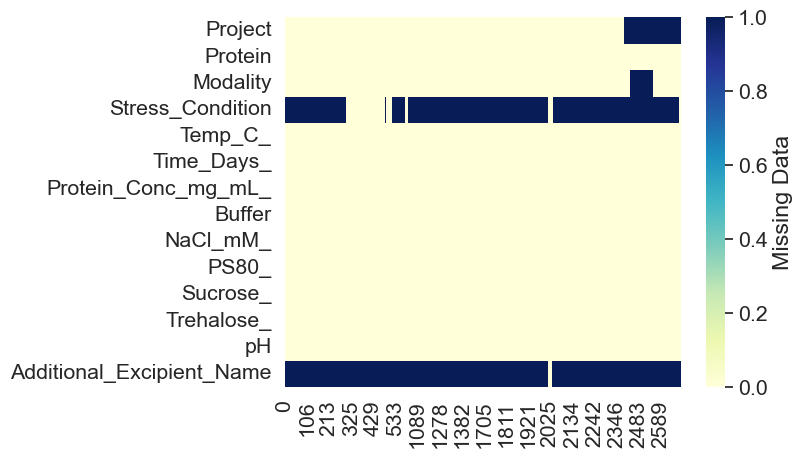

In [8]:
# missing data visualization across identifiers and formulation factors
sns.set(font_scale=1.4)
sns.heatmap(df[cols_group + cols_feature0].isnull().transpose(), cmap="YlGnBu",
            cbar_kws={'label': 'Missing Data'})
plt.show()

NaCl_mM_ [  0  50 150  75]
PS80_ [0.   0.02]
Sucrose_ [0.  7.  9.  7.5 5. ]
Trehalose_ [0 7 9]
pH [5.   6.2  6.8  5.6  5.5  6.5  6.   4.5  5.2  7.4  4.3  4.7  4.85 3.9
 4.4  4.9  5.4  5.63 4.6  5.1  4.2  5.9  6.1  6.7  4.   7.  ]


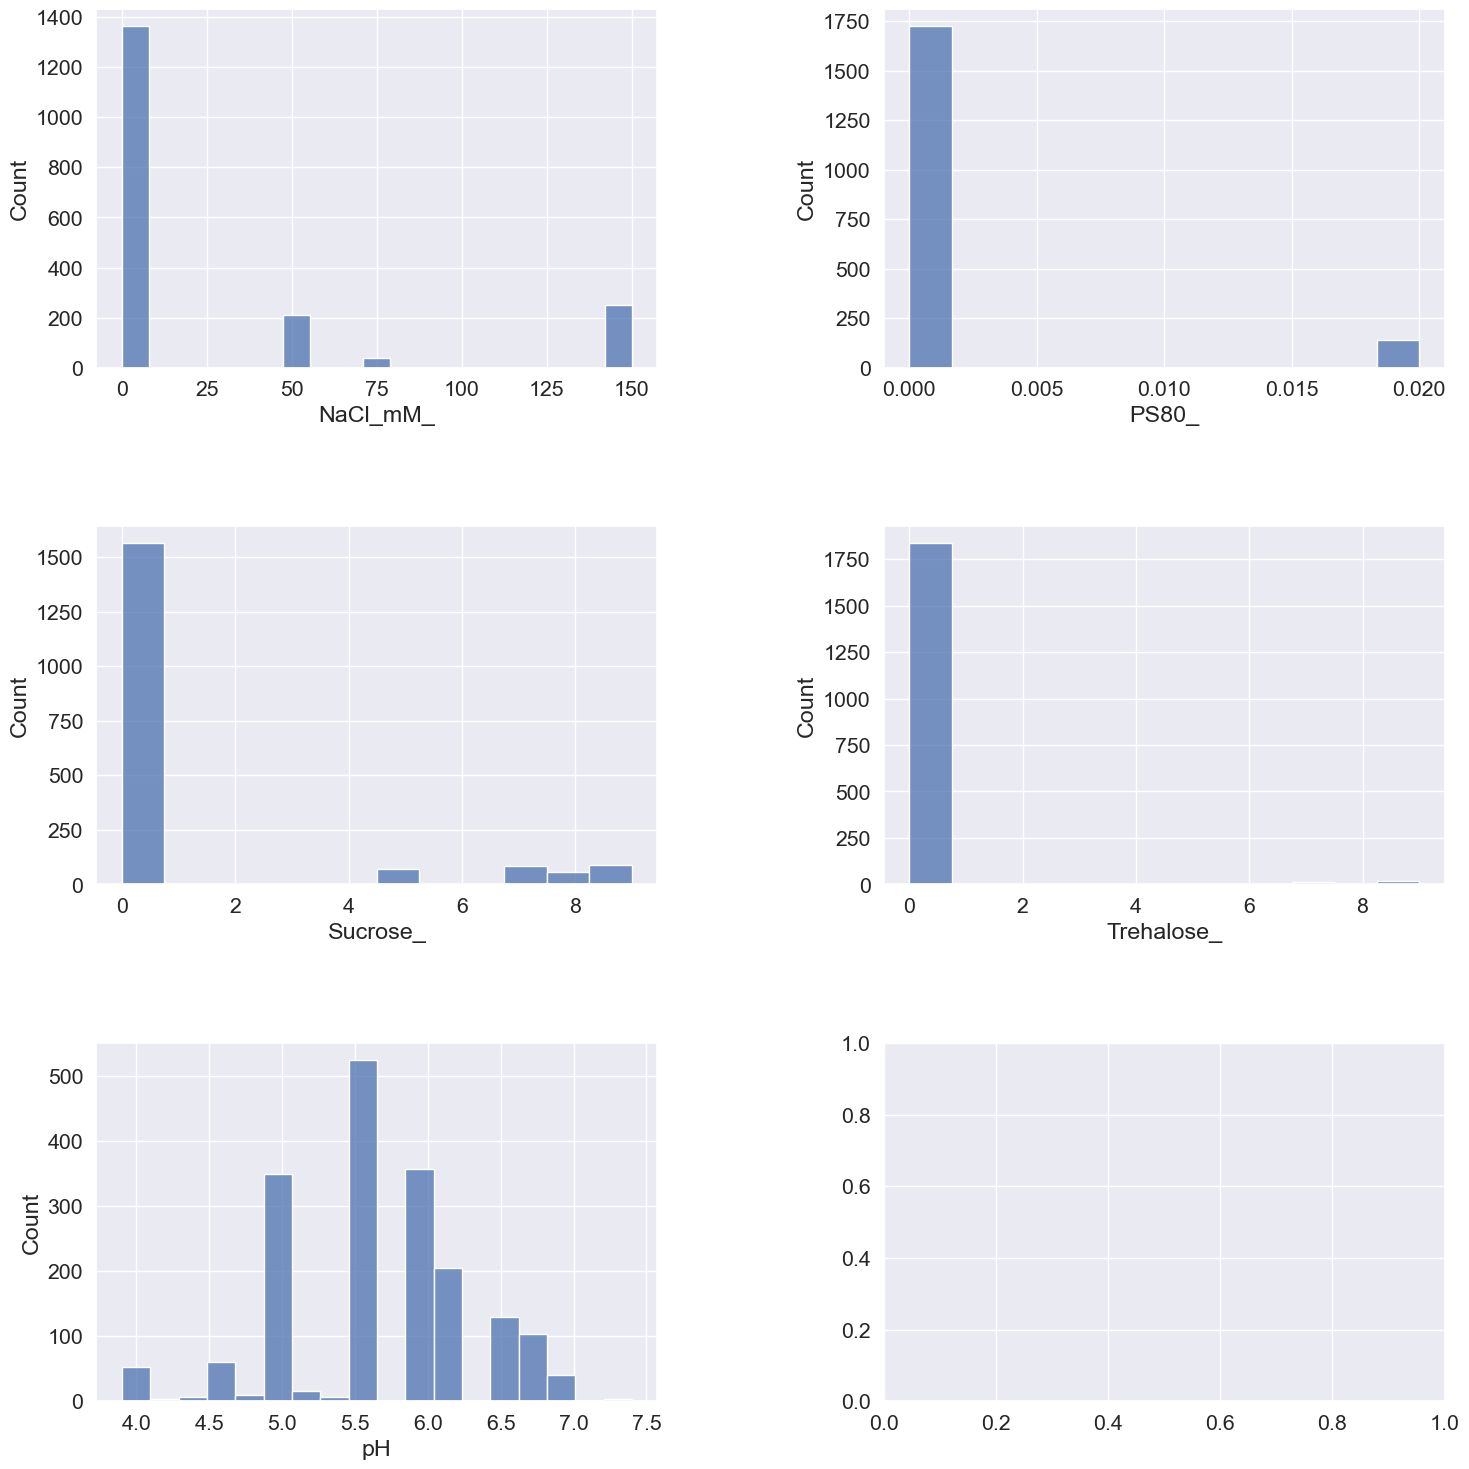

In [9]:
#Distributions of numeric features across all groups
fig, axes = plt.subplots(3,2, figsize=(15, 15))
#fig, axes = plt.subplots(10,3, figsize=(20, 20))
ax = axes.flatten()

for i, col in enumerate(cols_feature_numeric):
    print(col,df[col].unique())
    sns.histplot(df[col], ax=ax[i]) # histogram call
    #ax[i].set_title(col)
    # remove scientific notation for both axes
    ax[i].ticklabel_format(style='plain', axis='both')

fig.tight_layout(w_pad=6, h_pad=4) # change padding
#figName = 'featureDist.jpg'
#plt.savefig(os.path.join(figPath,figName))
plt.show()

Buffer ['Acetate' 'Citrate' 'Histidine' 'Phosphate' 'Glutamate' 'Succinate']
0


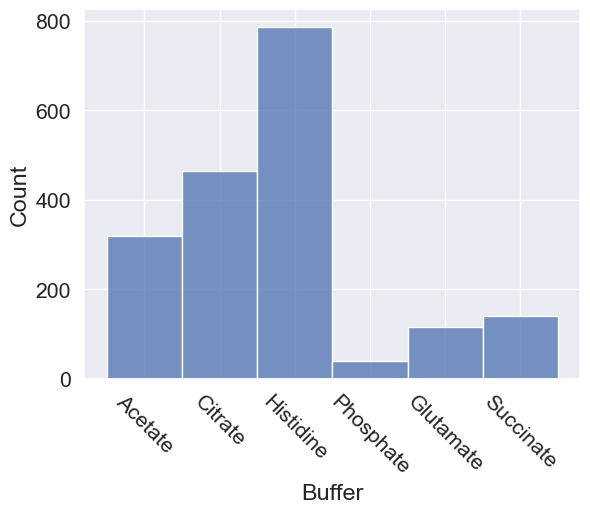

Additional_Excipient_Name [nan '  0.5%MoNi ' ' 1%SBebCD' '002%PO188' '002%PS20' '002%PS80'
 '005%MoNi' '05%MoNI' '1%HPbCD' '1%HPgCD' '1%MoNi' '1%SBEbCD' '1%gCD']
1843


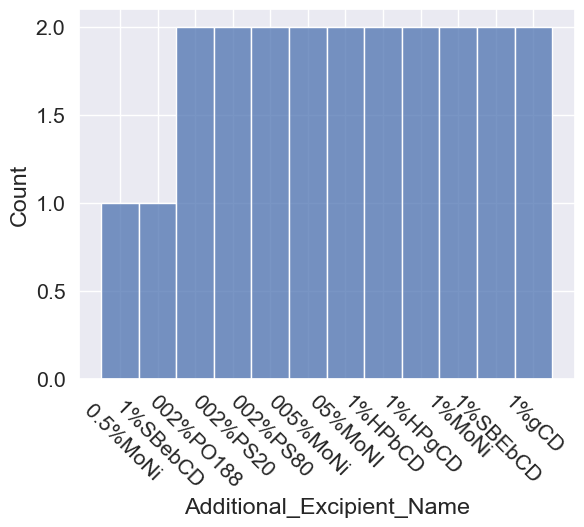

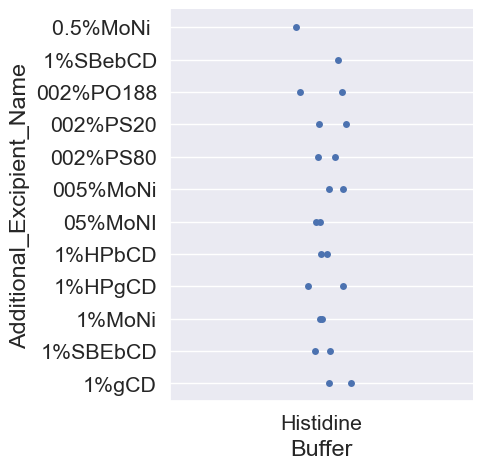

In [10]:
#Distributions of cate features
sns.set(font_scale=1.4)
for i, col in enumerate(['Buffer','Additional_Excipient_Name']):
    print(col,df[col].unique())
    print(df[col].isna().sum())
    #sns.catplot(data=df, x="Buffer", y="pH", jitter=False)
    sns.histplot(df[col]) 
    fig.tight_layout(w_pad=6, h_pad=4) # change padding
    plt.xticks(rotation=-45)
    plt.show()
    #ax[i].set_title(col)
sns.catplot(data=df[~df['Additional_Excipient_Name'].isna()], x="Buffer", y="Additional_Excipient_Name", jitter=True)

In [11]:
# Remove entry with Additional_Excipients

df.drop(df[~df['Additional_Excipient_Name'].isnull()].index, inplace=True)

cols_feature0 = ['Buffer','NaCl_mM_', 'PS80_', 'Sucrose_','Trehalose_','pH',
                 'Additional_Excipient_Name']
print(len(df))

1843


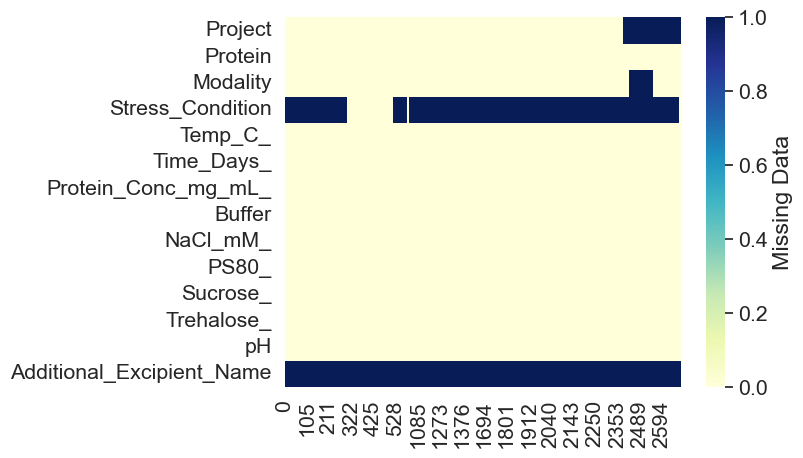

In [12]:
# missing data visualization across identifiers and formulation factors
sns.set(font_scale=1.4)
sns.heatmap(df[cols_group + cols_feature0].isnull().transpose(), cmap="YlGnBu",
            cbar_kws={'label': 'Missing Data'})
plt.show()

## split data into group by identifiers

In [13]:
result = df.groupby(cols_group)['Protein_Conc_mg_mL_'].agg(['min', 'max'])
result

min  \
Project     Protein       Modality Stress_Condition Temp_C_ Time_Days_ Protein_Conc_mg_mL_          
FAP-TriNKET DAB013887     BsAb     Thermal Stress    5.0    10.0       1.00                  1.00   
                                                     50.0   10.0       1.00                  1.00   
            DAB014071     BsAb     Thermal Stress    5.0    10.0       1.00                  1.00   
                                                     50.0   10.0       1.00                  1.00   
            DAB014072     BsAb     Thermal Stress    5.0    10.0       1.00                  1.00   
...                                                                                           ...   
Surfactant  DCC000706_005 ADC      Thermal Stress    40.0   14.0       21.60                21.60   
            Trab          ADC      Thermal Stress   -80.0   0.0        1.61                  1.61   
                                                     40.0   14.0       1.61                  1.61   
Trop2       DCC000770_032 ADC      Thermal Stress    25.0   0.0        5.00                  5.00   
                                                     60.0   5.0        5.00                  5.00   

                                                                                              max  
Project     Protein       Modality Stress_Condition Temp_C_ Time_Days_ Protein_Conc_mg_mL_         
FAP-TriNKET DAB013887     BsAb     Thermal Stress    5.0    10.0       1.00                  1.00  
                                                     50.0   10.0       1.00                  1.00  
            DAB014071     BsAb     Thermal Stress    5.0    10.0       1.00                  1.00  
                                                     50.0   10.0       1.00                  1.00  
            DAB014072     BsAb     Thermal Stress    5.0    10.0       1.00                  1.00  
...                                                                                           ...  
Surfactant  DCC000706_005 ADC      Thermal Stress    40.0   14.0       21.60                21.60  
            Trab          ADC      Thermal Stress   -80.0   0.0        1.61                  1.61  
                                                     40.0   14.0       1.61                  1.61  
Trop2       DCC000770_032 ADC      Thermal Stress    25.0   0.0        5.00                  5.00  
                                                     60.0   5.0        5.00                  5.00  

[136 rows x 2 columns]

In [14]:
# Update the sample identifier 
"""
    The protein concentration may deviate one from another in an acceptable range
    Thus, we remove the Protein concentration from sample identifier
"""
cols_group = ['Project','Protein', 'Modality','Stress_Condition','Temp_C_', 'Time_Days_']

#get unique levels for identifiers and count for number of missing data

for col in cols_group:
    print(col,'identifier has',df[col].isna().sum(),'missing data points')
    print(df[col].unique())

Project identifier has 272 missing data points
['aTau' 'CD40' 'CEACAM5' 'FAP-TriNKET' 'IL-2Ra' 'Surfactant' 'Sutro IL-2'
 'TRACTr Nectin-4' 'Trop2' nan]
Protein identifier has 0 missing data points
['03BHZ' '69BHV' 'MK-2032' '68BHS' 'TDI' 'AB0411' 'AB0621' '65BKD' '98BLE'
 '99BLE' '64BLJ' 'DAB013887' 'DAB014071' 'DAB014072' 'DAB014074' 'DNB547'
 'DNB553' 'DNB557' 'DNB558' '21BMT' '48BMP' 'DAB015692_013'
 'DCC000492_005' 'DCC000674_005' 'DCC000706_005' 'Trab' 'SP10482'
 'SP009849' 'SP10478' 'SP10784' 'DAB014234' 'DAB014235' 'DAB014236'
 'DAB014238' 'DCC000770_007' 'DAB0156292_012' 'DAB0156292_013'
 'DCC000363_035' 'DCC000770_035' 'DCC000238_004' 'DCC000250_003'
 'DCC000712_002' 'DCC000159_003' 'DCC000770_032' 'DCC_1A' 'DCC_2B'
 'MK3475' 'Enhertu' 'ROR1' 'VLS-101' 'VLS-231']
Modality identifier has 108 missing data points
['mAb' 'BsAb' 'Fusion Protein' 'ADC' 'polymer conjugate' 'Trispecific'
 'Fab' nan]
Stress_Condition identifier has 1609 missing data points
[nan 'Thermal Stress']
Temp_

30
The list of indices greater than or equal to n_data_th : [1, 3, 5, 7, 8, 9, 10, 11]
8
224


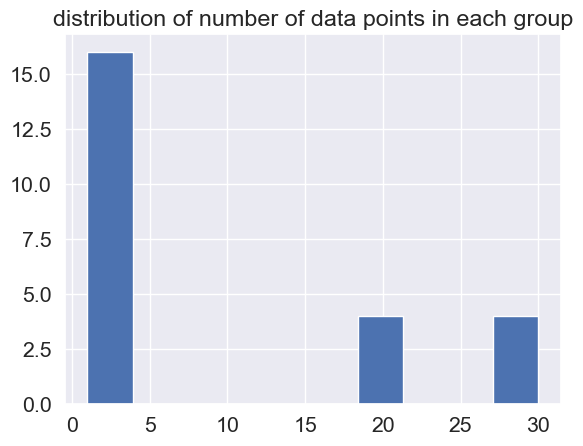

In [15]:
# split dataframe using gropuby
is_drop_na = True
if(is_drop_na):
    n_data_th = 20
else:
    n_data_th = 30
splits = list(df.groupby(cols_group,dropna=is_drop_na))
ndata = [len(df[1]) for df in splits]
ndata_str = [str(e) for e in ndata]
#print(','.join(ndata_str))
plt.hist(ndata)
plt.title('distribution of number of data points in each group')
print(max(ndata))#21

res = [idx for idx, val in enumerate(ndata) if val >= n_data_th]
print("The list of indices greater than or equal to n_data_th : " + str(res))
print(len(res))
print(np.sum(ndata))

In [16]:
from sklearn.decomposition import PCA
from numpy.linalg import norm

def pca_similarity_factor(ts1: np.array, ts2: np.array, components = 3) -> float:
    n_samples1, n_features1 = np.shape(ts1)
    n_samples2, n_features2 = np.shape(ts2)
    components1 = min(n_samples1, n_features1)
    components2 = min(n_samples2, n_features2)
    new_components = min(components1,components2,components)
    pca1 = PCA(n_components = new_components)
    pca2 = PCA(n_components = new_components)
    pca1.fit(ts1)
    pca2.fit(ts2)
    len_ev = len(pca1.explained_variance_)
    data1 = zip(pca1.explained_variance_,pca1.components_)
    data2 = zip(pca2.explained_variance_,pca2.components_)
    numerator = sum([ev1*ev2*(np.cos(angle_between(v1,v2))**2) for ev1,v1 in data1 for ev2,v2 in data2])
    denominator = sum([pca1.explained_variance_[i]*pca2.explained_variance_[i] for i in range(len_ev)])
    similarity_factor = numerator/denominator
    return similarity_factor

def angle_between(v1,v2):
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u,v2_u),-1.0,1.0))

def unit_vector(v):
    return v/np.linalg.norm(v)


In [17]:
cols_feature01 = [item for item in cols_feature0 if item != 'Additional_Excipient_Name']

print(cols_feature01)
print(cols_feature0)

['Buffer', 'NaCl_mM_', 'PS80_', 'Sucrose_', 'Trehalose_', 'pH']
['Buffer', 'NaCl_mM_', 'PS80_', 'Sucrose_', 'Trehalose_', 'pH', 'Additional_Excipient_Name']


In [18]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(df[['Buffer']])

OneHotEncoder(handle_unknown='ignore')

In [19]:
ohe_feat_names = enc.get_feature_names_out(['Buffer'])
ohe_feat_names

array(['Buffer_Acetate', 'Buffer_Citrate', 'Buffer_Glutamate',
       'Buffer_Histidine', 'Buffer_Phosphate', 'Buffer_Succinate'],
      dtype=object)

In [20]:
from sklearn.metrics.pairwise import cosine_similarity

n_group = len(splits)
simM = np.zeros([n_group,n_group])

for i1,g1 in enumerate(splits):
    df1 = g1[1]
    
    #split features into numeric and categorical
    numeric_feat = df1[cols_feature01].select_dtypes(include=[np.number])
    cate_feat = df1[cols_feature01].select_dtypes(exclude=[np.number])
    numeric_feat.reset_index(inplace = True, drop = True)
    cate_feat.reset_index(inplace = True, drop = True)

    #convert cate features to one-hot encoding
    #one_hot_cate_feat = pd.get_dummies(cate_feat, columns = ['Buffer'])
    one_hot_cate_feat = pd.DataFrame(enc.transform(cate_feat).toarray(),columns = ohe_feat_names)

    df1_feat = pd.concat([numeric_feat,one_hot_cate_feat],axis = 1)
    arr1 = df1_feat.to_numpy()

    for i2,g2 in enumerate(splits):
        df2 = g2[1]
    
        #split features into numeric and categorical
        numeric_feat = df2[cols_feature01].select_dtypes(include=[np.number])
        cate_feat = df2[cols_feature01].select_dtypes(exclude=[np.number])
        numeric_feat.reset_index(inplace = True, drop = True)
        cate_feat.reset_index(inplace = True, drop = True)

        #convert cate features to one-hot encoding
        #one_hot_cate_feat = pd.get_dummies(cate_feat, columns = ['Buffer'])
        one_hot_cate_feat = pd.DataFrame(enc.transform(cate_feat).toarray(),columns = ohe_feat_names)

        df2_feat = pd.concat([numeric_feat,one_hot_cate_feat],axis = 1)
        arr2 = df2_feat.to_numpy()
        
        if i1==i2:
            simM[i1,i2] = 1
        else:
            if np.shape(arr2)[0]==1:
                simM[i1,i2] = np.mean(cosine_similarity(arr2.reshape(1,arr2.shape[1]),arr1))
            elif np.shape(arr1)[0]==1:
                simM[i1,i2] = np.mean(cosine_similarity(arr1.reshape(1,arr1.shape[1]),arr2))
            else:
                simM[i1,i2] = pca_similarity_factor(arr1,arr2,components = 3)

<Axes: >

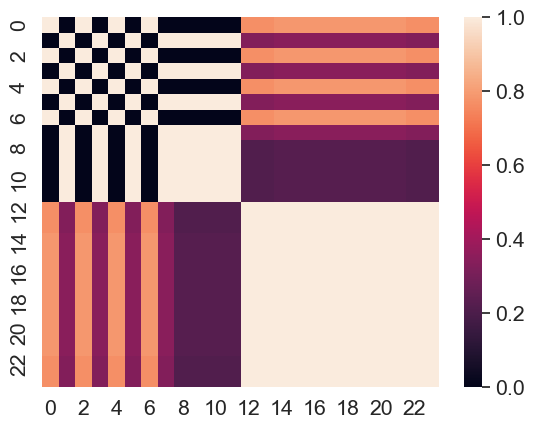

In [21]:
sns.heatmap(simM)


In [57]:
[(i,df[0],len(df[1])) for i,df in enumerate(splits)]

[(0, ('FAP-TriNKET', 'DAB013887', 'BsAb', 'Thermal Stress', 5.0, 10.0), 2),
 (1, ('FAP-TriNKET', 'DAB013887', 'BsAb', 'Thermal Stress', 50.0, 10.0), 21),
 (2, ('FAP-TriNKET', 'DAB014071', 'BsAb', 'Thermal Stress', 5.0, 10.0), 2),
 (3, ('FAP-TriNKET', 'DAB014071', 'BsAb', 'Thermal Stress', 50.0, 10.0), 21),
 (4, ('FAP-TriNKET', 'DAB014072', 'BsAb', 'Thermal Stress', 5.0, 10.0), 2),
 (5, ('FAP-TriNKET', 'DAB014072', 'BsAb', 'Thermal Stress', 50.0, 10.0), 21),
 (6, ('FAP-TriNKET', 'DAB014074', 'BsAb', 'Thermal Stress', 5.0, 10.0), 2),
 (7, ('FAP-TriNKET', 'DAB014074', 'BsAb', 'Thermal Stress', 50.0, 10.0), 21),
 (8, ('IL-2Ra', 'DNB547', 'Fusion Protein', 'Thermal Stress', 40.0, 12.0), 30),
 (9, ('IL-2Ra', 'DNB553', 'Fusion Protein', 'Thermal Stress', 40.0, 12.0), 30),
 (10,
  ('IL-2Ra', 'DNB557', 'Fusion Protein', 'Thermal Stress', 40.0, 12.0),
  30),
 (11,
  ('IL-2Ra', 'DNB558', 'Fusion Protein', 'Thermal Stress', 40.0, 12.0),
  30),
 (12, ('Surfactant', 'DAB015692_013', 'ADC', 'Thermal 

In [ ]:
cols_xy = cols_feature01 + cols_target
simM_xy = np.zeros([n_group,n_group])
splits = list(df.groupby(cols_group,dropna=is_drop_na))

for i1,g1 in enumerate(splits):
    df1 = g1[1][cols_xy]
    df1_adj = df1.dropna()
    if len(df1_adj)==0:
        simM_xy[i1,i2] = 0
    else:
        #split features into numeric and categorical
        numeric_feat = df1_adj[cols_xy].select_dtypes(include=[np.number])
        cate_feat = df1_adj[cols_xy].select_dtypes(exclude=[np.number])
        numeric_feat.reset_index(inplace = True, drop = True)
        cate_feat.reset_index(inplace = True, drop = True)

        #convert cate features to one-hot encoding
        one_hot_cate_feat = pd.DataFrame(enc.transform(cate_feat).toarray(),columns = ohe_feat_names)

        df1_feat = pd.concat([numeric_feat,one_hot_cate_feat],axis = 1)
        arr1 = df1_feat.to_numpy()
    
        for i2,g2 in enumerate(splits):
            df2 = g2[1][cols_xy]
            df2_adj = df2.dropna()
            if len(df2_adj)==0:
                simM_xy[i1,i2] = 0
            else:
                #split features into numeric and categorical
                numeric_feat = df2_adj[cols_xy].select_dtypes(include=[np.number])
                cate_feat = df2_adj[cols_xy].select_dtypes(exclude=[np.number])
                numeric_feat.reset_index(inplace = True, drop = True)
                cate_feat.reset_index(inplace = True, drop = True)

                #convert cate features to one-hot encoding
                one_hot_cate_feat = pd.DataFrame(enc.transform(cate_feat).toarray(),columns = ohe_feat_names)

                df2_feat = pd.concat([numeric_feat,one_hot_cate_feat],axis = 1)
                arr2 = df2_feat.to_numpy()
        

                if i1==i2:
                    simM_xy[i1,i2] = 1
                else:
                    if np.shape(arr2)[0]==1:
                        simM_xy[i1,i2] = np.mean(cosine_similarity(arr2.reshape(1,arr2.shape[1]),arr1))
                    elif np.shape(arr1)[0]==1:
                        simM_xy[i1,i2] = np.mean(cosine_similarity(arr1.reshape(1,arr1.shape[1]),arr2))
                    else:
                        simM_xy[i1,i2] = pca_similarity_factor(arr1,arr2,components = 3)

<Axes: >

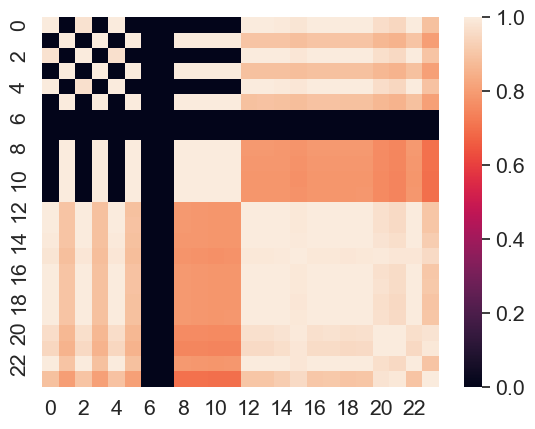

In [48]:
sns.heatmap(simM_xy)

In [54]:
#cols_y = ['Buffer'] + cols_target
cols_y = cols_target
simM_y = np.zeros([n_group,n_group])
splits = list(df.groupby(cols_group,dropna=is_drop_na))

for i1,g1 in enumerate(splits):
    df1 = g1[1][cols_y]
    df1_adj = df1.dropna()
    if len(df1_adj)==0:
        simM_y[i1,i2] = 0
    else:
        """
        #split features into numeric and categorical
        numeric_feat = df1_adj[cols_y].select_dtypes(include=[np.number])
        cate_feat = df1_adj[cols_y].select_dtypes(exclude=[np.number])
        numeric_feat.reset_index(inplace = True, drop = True)
        cate_feat.reset_index(inplace = True, drop = True)

        #convert cate features to one-hot encoding
        one_hot_cate_feat = pd.DataFrame(enc.transform(cate_feat).toarray(),columns = ohe_feat_names)

        df1_feat = pd.concat([numeric_feat,one_hot_cate_feat],axis = 1)
        arr1 = df1_feat.to_numpy()
        """
        arr1 = df1_adj.to_numpy()
        
        for i2,g2 in enumerate(splits):
            df2 = g2[1][cols_y]
            df2_adj = df2.dropna()
            if len(df2_adj)==0:
                simM_y[i1,i2] = 0
            else:
                """
                #split features into numeric and categorical
                numeric_feat = df2_adj[cols_y].select_dtypes(include=[np.number])
                cate_feat = df2_adj[cols_y].select_dtypes(exclude=[np.number])
                numeric_feat.reset_index(inplace = True, drop = True)
                cate_feat.reset_index(inplace = True, drop = True)

                #convert cate features to one-hot encoding
                one_hot_cate_feat = pd.DataFrame(enc.transform(cate_feat).toarray(),columns = ohe_feat_names)

                df2_feat = pd.concat([numeric_feat,one_hot_cate_feat],axis = 1)
                arr2 = df2_feat.to_numpy()
                """
                arr2 = df2_adj.to_numpy()
                
                if i1==i2:
                    simM_y[i1,i2] = 1
                else:
                    if np.shape(arr2)[0]==1:
                        simM_y[i1,i2] = np.mean(cosine_similarity(arr2.reshape(1,arr2.shape[1]),arr1))
                    elif np.shape(arr1)[0]==1:
                        simM_y[i1,i2] = np.mean(cosine_similarity(arr1.reshape(1,arr1.shape[1]),arr2))
                    else:
                        simM_y[i1,i2] = pca_similarity_factor(arr1,arr2,components = 3)

<Axes: >

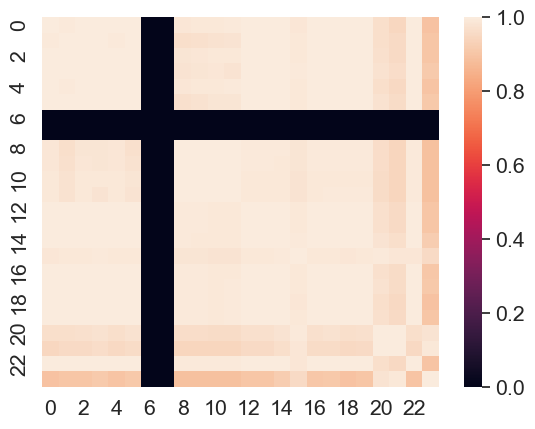

In [55]:
sns.heatmap(simM_y)